# Homework 4: Conversation Modeling and decoding

# Part 1 Modeling

## 1.1 Attention visulization

In [0]:
### set up the model and complete the corresponding task

### the pretrained model was trained in ~2 hours, i.e. you can expect attention maps
### to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input

import re
from collections import Counter
from tqdm import tqdm
import json
from torch.utils.data import Dataset, DataLoader
import torch

In [0]:
RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

In [0]:
class ChatDictionary(object):
    """
    Simple dict loader
    """
    def __init__(self, dict_file_path):
        self.word2ind = {}  # word:index
        self.ind2word = {}  # index:word
        self.counts = {}  # word:count

        dict_raw = open(dict_file_path, 'r').readlines()
        
        for i, w in enumerate(dict_raw):
            _word, _count = w.strip().split('\t')
            if _word == '\\n':
                _word = '\n'
            self.word2ind[_word] = i
            self.ind2word[i] = _word
            self.counts[_word] = _count
            
    def t2v(self, tokenized_text):
        return [self.word2ind[w] if w in self.counts else self.word2ind['__unk__'] for w in tokenized_text]

    def v2t(self, list_ids):
        return ' '.join([self.ind2word[i] for i in list_ids])
    
    def pred2text(self, tensor):
        result = []
        for i in range(tensor.size(0)):
            if tensor[i].item() == '__end__'  or tensor[i].item() == '__null__':  # null is pad
                break
            else:
                result.append(self.ind2word[tensor[i].item()])
        return ' '.join(result)
    
    def __len__(self):
        return len(self.counts)

In [0]:
class ChatDataset(Dataset):
    """
    Json dataset wrapper
    """
    
    def __init__(self, dataset_file_path, dictionary, dt='train'):
        super().__init__()
        
        json_text = open(dataset_file_path, 'r').readlines()
        self.samples = []
        
        for sample in tqdm(json_text):
            sample = sample.rstrip()
            sample = json.loads(sample)
            _inp_toked = RETOK.findall(sample['text'])
            _inp_toked_id = dictionary.t2v(_inp_toked)

            sample['text_vec'] = torch.tensor(_inp_toked_id, dtype=torch.long)
            
            # train and valid have different key names for target
            if dt == 'train':
                _tar_toked = RETOK.findall(sample['labels'][0]) + ['__end__']
            elif dt == 'valid':
                _tar_toked = RETOK.findall(sample['eval_labels'][0]) + ['__end__']
                
            _tar_toked_id = dictionary.t2v(_tar_toked)
            
            sample['target_vec'] = torch.tensor(_tar_toked_id, dtype=torch.long)
            
            self.samples.append(sample)
            
    def __getitem__(self, i):
        return self.samples[i]['text_vec'], self.samples[i]['target_vec']
    
    def __len__(self):
        return len(self.samples)

In [0]:
# pad_tensor function implements padding of a given tensor using the specified PAD token.
def pad_tensor(tensors, sort=True, pad_token=0):
    rows = len(tensors)
    lengths = [len(i) for i in tensors]
    max_t = max(lengths)
        
    output = tensors[0].new(rows, max_t)
    output.fill_(pad_token)  # 0 is a pad token here
    
    for i, (tensor, length) in enumerate(zip(tensors, lengths)):
        output[i,:length] = tensor

    return output, lengths

# argsort reorders the given list using provided keys. This is necessary for unpacking. 
def argsort(keys, *lists, descending=False):
    """Reorder each list in lists by the (descending) sorted order of keys.
    :param iter keys: Keys to order by.
    :param list[list] lists: Lists to reordered by keys's order.
                             Correctly handles lists and 1-D tensors.
    :param bool descending: Use descending order if true.
    :returns: The reordered items.
    """
    ind_sorted = sorted(range(len(keys)), key=lambda k: keys[k])
    if descending:
        ind_sorted = list(reversed(ind_sorted))
    output = []
    for lst in lists:
        if isinstance(lst, torch.Tensor):
            output.append(lst[ind_sorted])
        else:
            output.append([lst[i] for i in ind_sorted])
    return output

# batchify uses both previous function to make a minibatch which is ready to be packed.
def batchify(batch):
    inputs = [i[0] for i in batch]
    labels = [i[1] for i in batch]
    
    input_vecs, input_lens = pad_tensor(inputs)
    label_vecs, label_lens = pad_tensor(labels)
    
    # sort only wrt inputs here for encoder packinng
    input_vecs, input_lens, label_vecs, label_lens = argsort(input_lens, input_vecs, input_lens, label_vecs, label_lens, descending=True)

    return {
        "text_vecs": input_vecs,
        "text_lens": input_lens,
        "target_vecs": label_vecs,
        "target_lens": label_lens,
        'use_packed': True
    }

In [6]:
# loading datasets and dictionary

# downloading pretrained models and data

### DOWNLOADING THE FILES
import os

### persona chat dataset
if not os.path.exists('./dict'):
    !wget "https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h" -O './dict'
if not os.path.exists('./train.jsonl'):
    !wget "https://nyu.box.com/shared/static/aqp0jyjaixjmukm5asasivq2bcfze075.jsonl" -O './train.jsonl'
if not os.path.exists('./valid.jsonl'):
    !wget "https://nyu.box.com/shared/static/eg4ivddtqib2hkf1k8rkxnmzmo0cq27p.jsonl" -O './valid.jsonl'

if not os.path.exists('./chat_model_best_22.pt'):
    !wget "https://nyu.box.com/shared/static/24zsynuks8nzg7530tgakzh8o62id9xa.pt" -O './chat_model_best_22.pt'

chat_dict = ChatDictionary('./dict')
train_dataset = ChatDataset('./train.jsonl', chat_dict)
valid_dataset = ChatDataset('./valid.jsonl', chat_dict, 'valid')

--2019-11-13 02:52:18--  https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h
Resolving nyu.box.com (nyu.box.com)... 103.116.4.197
Connecting to nyu.box.com (nyu.box.com)|103.116.4.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/sj9f87tofpicll89xbc154pmbztu5q4h [following]
--2019-11-13 02:52:19--  https://nyu.box.com/public/static/sj9f87tofpicll89xbc154pmbztu5q4h
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/sj9f87tofpicll89xbc154pmbztu5q4h [following]
--2019-11-13 02:52:19--  https://nyu.app.box.com/public/static/sj9f87tofpicll89xbc154pmbztu5q4h
Resolving nyu.app.box.com (nyu.app.box.com)... 103.116.4.199
Connecting to nyu.app.box.com (nyu.app.box.com)|103.116.4.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!ZoLg_OtBkhsWSUO4uqeRoN

100%|██████████| 7801/7801 [00:00<00:00, 12716.89it/s]


In [0]:
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=batchify, batch_size=128)
                          #batch_size=256)
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=128)
                          #batch_size=256)

In [0]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class EncoderRNN(nn.Module):
    """Encodes the input context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx=0, dropout=0, shared_lt=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_idx = pad_idx
        
        if shared_lt is None:
            self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
        else:
            self.embedding = shared_lt
            
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        
    def forward(self, text_vec, text_lens, hidden=None, use_packed=True):
        embedded = self.embedding(text_vec)
        
        attention_mask = text_vec.ne(self.pad_idx)
        

        embedded = self.dropout(embedded)
        if use_packed is True:
            embedded = pack_padded_sequence(embedded, text_lens, batch_first=True)

        # Applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence.
        output, hidden = self.gru(embedded, hidden)

        if use_packed is True:
            output, output_lens = pad_packed_sequence(output, batch_first=True)
        
        return output, hidden, attention_mask

    
class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        decoder_hidden = decoder_hidden
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
                                          ## input, innitial hidden state
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, decoder_hidden, encoder_output, attention_mask)
            
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)

  #### from the first beggining word:
      #### word embedding + encoder_hidden --> decoder_output,decoder hidden
      #### decoder_output + attention --> decoder_output_attended
      #### output.append(decoder_output_attended)
  #### output = torch.cat(output)
  #### scores = nn.Linear(hidden_size,,vocab_length)



        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_hidden, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log
    
    
class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, decoder_output, decoder_hidden, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()

        encoder_output_t = encoder_output.transpose(1,2)

         #Performs a batch matrix-matrix product of matrices
        #print(decoder_output.shape)
        #print(encoder_output_t.shape)
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)

        attention_scores.masked_fill_((~attention_mask), -10e5)
        #normalize
        attention_weights = self.softmax(attention_scores)

        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)

        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)

        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)

        return output, attention_weights
    
    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_enc'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

load_pretrained = True
    
if load_pretrained is True:
    if current_device == 'cuda':
        model_pt = torch.load('./chat_model_best_22.pt')
    else:
        model_pt = torch.load('./chat_model_best_22.pt', map_location=torch.device('cpu'))
    opts = model_pt['opts']
    
    model = seq2seq(opts)
    model.load_state_dict(model_pt['state_dict'])
    model.to(current_device)
    
else:
    
    opts = {}

    opts['vocab_size'] = len(chat_dict)
    opts['hidden_size'] = 512
    opts['embedding_size'] = 256
    opts['num_layers_enc'] = 2
    opts['num_layers_dec'] = 2
    opts['dropout'] = 0.3
    opts['encoder_shared_lt'] = True

    model = seq2seq(opts)
    model.to(current_device)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), 0.01, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

In [0]:
plot_cache = []

best_val_loss = 100

for epoch in range(50):
    
    model.train()
    sum_loss = 0
    sum_tokens = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        text_vecs = batch['text_vecs'].to('cuda')
        target_vecs = batch['target_vecs'].to('cuda')
        
        encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
        
        decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        
        scores = decoder_output.view(-1, decoder_output.size(-1))
        
        loss = criterion(scores, target_vecs.view(-1))
        sum_loss += loss.item()
        
        num_tokens = target_vecs.ne(0).long().sum().item()
        loss /= num_tokens
        
        sum_tokens += num_tokens
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            avg_train_loss = sum_loss/sum_tokens
            print("iter {} train loss = {}".format(i, sum_loss/sum_tokens))
            
    val_loss = 0
    val_tokens = 0
    for i, batch in enumerate(valid_loader):
        model.eval()
        
        text_vecs = batch['text_vecs'].to('cuda')
        target_vecs = batch['target_vecs'].to('cuda')
        
        encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
        
        decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        
        scores = decoder_output.view(-1, decoder_output.size(-1))
        
        loss = criterion(scores, target_vecs.view(-1))
        
        num_tokens = target_vecs.ne(0).long().sum().item()
        
        val_tokens += num_tokens
        val_loss += loss.item()
        
    avg_val_loss = val_loss/val_tokens
    scheduler.step(avg_val_loss)
        
    print("Epoch {} valid loss = {}".format(epoch, avg_val_loss))
    
    plot_cache.append( (avg_train_loss, avg_val_loss) )
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        
        torch.save({
        'state_dict': model.state_dict(),
        'opts': opts,
        'plot_cache': plot_cache,
            }, f'./chat_model_best_{epoch}.pt')

iter 0 train loss = 9.749751731393419
iter 100 train loss = 9.752530143180811
iter 200 train loss = 9.752508253491461
iter 300 train loss = 9.752571878409444
iter 400 train loss = 9.75258270834245
iter 500 train loss = 9.7525439747233
iter 600 train loss = 9.752528775182096
iter 700 train loss = 9.75253705420291
iter 800 train loss = 9.752545242557074
iter 900 train loss = 9.752574553269607
iter 1000 train loss = 9.752573190987558
Epoch 0 valid loss = 9.753682957428103
iter 0 train loss = 9.754490021161704


KeyboardInterrupt: ignored

In [0]:
model = seq2seq(opts).to('cuda')
model.load_state_dict(torch.load('chat_model_best_22.pt')['state_dict'])

<All keys matched successfully>

In [0]:
import random
def attention_weights(valid_data): 
#return the attention weights of a randomly selected sample from validation sets
  for i, batch in enumerate(valid_data):
          model.eval()
          example_index = random.randint(1,128)
          text_vecs = batch['text_vecs'].to('cuda')
          target_vecs = batch['target_vecs'].to('cuda')

          encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
          
          decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
          attn_w_log_example = [i[example_index] for i in attn_w_log]


          
          return(text_vecs[example_index],target_vecs[example_index],attn_w_log_example)
          break
            
        
    

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def attention_map(attention_weights,inputs,target,adjust_size = True): 
#If adjust = true, only present the range that has attention weight over 0
  fig, ax = plt.subplots(figsize=(20, 30))
  plot_data = np.array([xi.cpu().detach().numpy() for xi in attn_w_log_example])

  inputs_plot = inputs.cpu().detach().numpy()
  target_plot = target.cpu().detach().numpy()
  inputs_token = [chat_dict.ind2word[ind] for ind in inputs_plot]
  target_token = [chat_dict.ind2word[ind] for ind in target_plot]
  print('Input')
  print('-' * 50)
  print(inputs_token)
  print('Output')
  print('-' * 50)
  print(target_token)
  print('Attention heatmap')
  print('-' * 50)

  if adjust_size:
    inputs_size = np.count_nonzero(inputs_plot)
    target_size = np.count_nonzero(target_plot)
    #cut_len = max(inputs_size,target_size)

    inputs_plot = inputs.cpu().detach().numpy()[:inputs_size]
    target_plot = target.cpu().detach().numpy()[:target_size]
    plot_data = plot_data[:inputs_size][:target_size]
  im = ax.imshow(plot_data.T)


  # We want to show all ticks...
  ax.set_yticks(np.arange(len(inputs_plot)))
  ax.set_xticks(np.arange(len(target_plot)))
  # ... and label them with the respective list entries
  inputs_token = [chat_dict.ind2word[ind] for ind in inputs_plot]
  target_token = [chat_dict.ind2word[ind] for ind in target_plot]
  ax.set_yticklabels(inputs_token)
  ax.set_xticklabels(target_token)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")
  plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  #for i in range(len(inputs_plot)):
      #for j in range(len(target_plot)):
        #if plot_data[i, j] != 0:
      
          #text = ax.text(j, i, plot_data[i][j],
                        #ha="center", va="center", color="w")
 

  ax.set_title("Heatmap of attention map")
  fig.tight_layout()
  plt.colorbar(im)
  plt.show()



### You present here:

Input
--------------------------------------------------
['your', 'persona', ':', 'i', "'", 'm', 'now', 'looking', 'for', 'a', 'new', 'job', '.', '\n', 'your', 'persona', ':', 'my', 'favorite', 'movie', 'is', 'friday', '.', '\n', 'your', 'persona', ':', 'i', 'am', 'a', 'doctor', '.', '\n', 'your', 'persona', ':', 'my', 'daughter', 'is', 'a', 'child', '__unk__', '.', '\n', 'hello', ',', 'i', "'", 'm', 'sitting', 'here', 'with', 'my', 'dog', '.', 'how', 'are', 'you', '?', '\n', 'i', "'", 'm', 'well', 'friend', '.', 'looking', 'for', 'new', 'employment', 'at', 'the', 'moment', '.', '\n', 'what', 'would', 'be', 'your', 'dream', 'job', '?', '\n', 'a', 'writer', '.', 'i', "'", 'm', 'currently', 'an', 'er', 'doctor', '.', '\n', 'what', 'was', 'the', 'worst', 'accident', 'you', 'have', 'seen', 'in', 'the', 'er', '?', '\n', 'a', 'man', 'had', 'his', 'throat', '__unk__', 'in', 'a', 'home', 'invasion', '\n', 'that', 'is', 'very', 'scary', '.', 'i', 'would', 'rather', 'stick', 'to', 'my', 'knittin

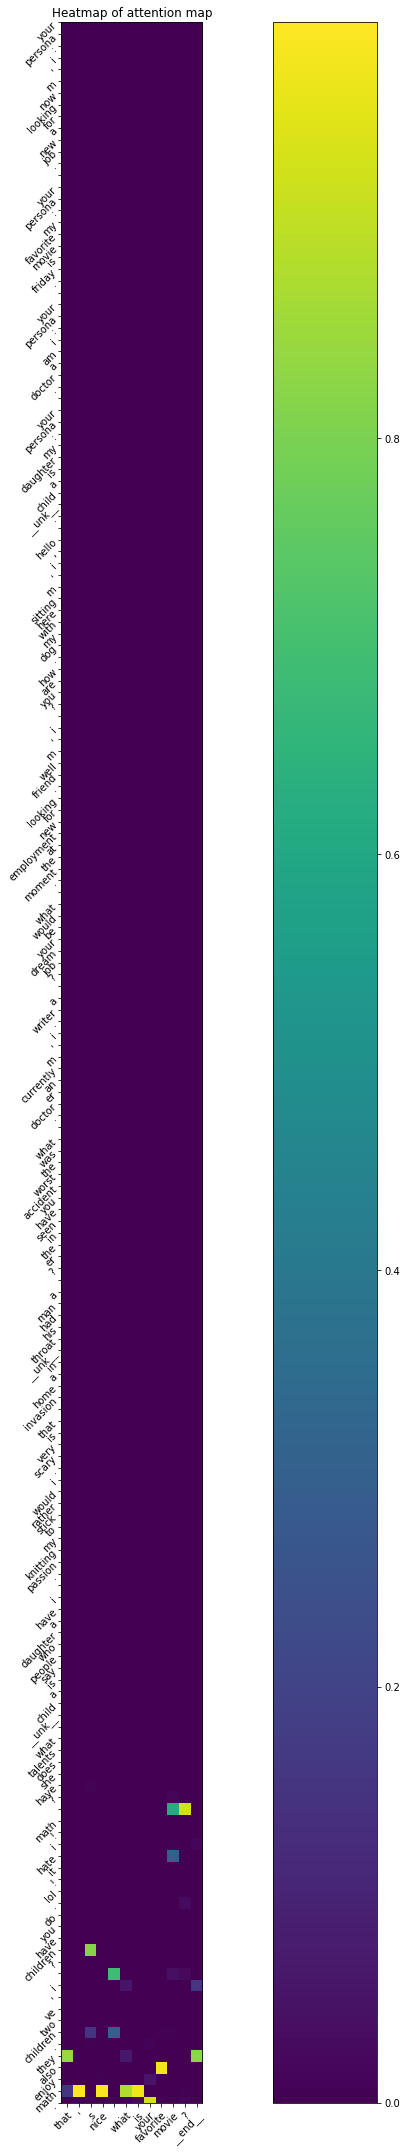

Input
--------------------------------------------------
['your', 'persona', ':', 'i', 'love', 'to', 'go', 'to', 'disney', 'world', 'every', 'year', '.', '\n', 'your', 'persona', ':', 'mickey', 'mouse', 'is', 'my', 'favorite', 'character', '.', '\n', 'your', 'persona', ':', 'i', 'play', 'with', 'my', 'friends', 'on', 'the', 'playground', '.', '\n', 'your', 'persona', ':', 'i', 'love', 'to', 'sing', 'songs', 'from', 'the', 'movie', 'frozen', '.', '\n', 'your', 'persona', ':', 'i', "'", 'm', 'in', 'the', 'third', 'grade', '.', '\n', 'hello', '!', 'i', 'was', 'three', 'when', 'i', 'learned', 'to', 'play', 'guitar', '!', '\n', 'hi', 'i', 'enjoy', 'disney', 'world', 'and', 'go', 'every', 'year', '\n', 'that', "'", 's', 'great', '.', 'i', 'really', 'like', '__unk__', '__unk__', '.', 'i', 'think', 'they', 'played', 'there', 'before', '.', '__null__', '__null__', '__null__', '__null__', '__null__', '__null__', '__null__', '__null__', '__null__', '__null__', '__null__', '__null__', '__null__', 

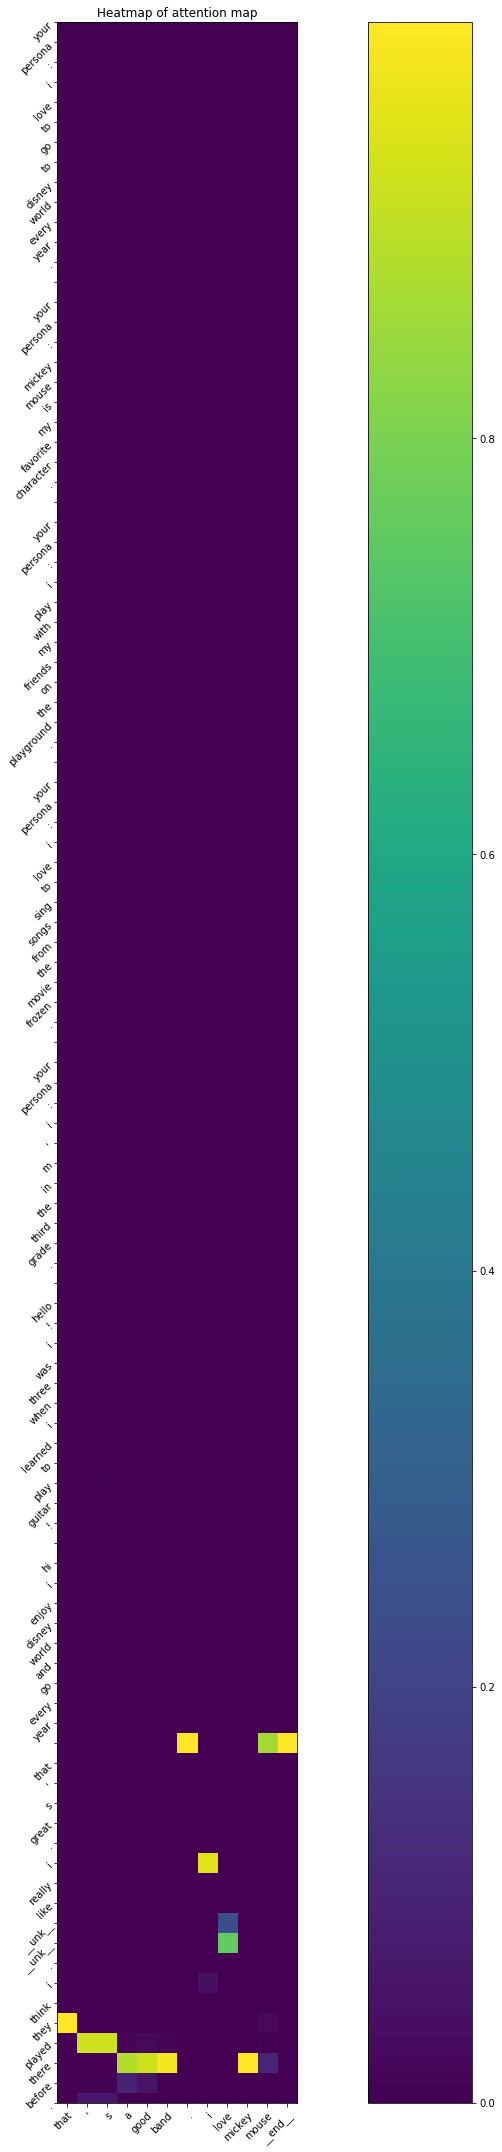

Input
--------------------------------------------------
['your', 'persona', ':', 'i', 'love', 'to', 'go', 'to', 'disney', 'world', 'every', 'year', '.', '\n', 'your', 'persona', ':', 'mickey', 'mouse', 'is', 'my', 'favorite', 'character', '.', '\n', 'your', 'persona', ':', 'i', 'play', 'with', 'my', 'friends', 'on', 'the', 'playground', '.', '\n', 'your', 'persona', ':', 'i', 'love', 'to', 'sing', 'songs', 'from', 'the', 'movie', 'frozen', '.', '\n', 'your', 'persona', ':', 'i', "'", 'm', 'in', 'the', 'third', 'grade', '.', '\n', 'hello', '!', 'i', 'was', 'three', 'when', 'i', 'learned', 'to', 'play', 'guitar', '!', '\n', 'hi', 'i', 'enjoy', 'disney', 'world', 'and', 'go', 'every', 'year', '\n', 'that', "'", 's', 'great', '.', 'i', 'really', 'like', '__unk__', '__unk__', '.', 'i', 'think', 'they', 'played', 'there', 'before', '.', '\n', 'that', "'", 's', 'a', 'good', 'band', '.', 'i', 'love', 'mickey', 'mouse', '\n', 'i', 'actually', 'grew', 'up', 'in', 'the', 'entertainment', 'indust

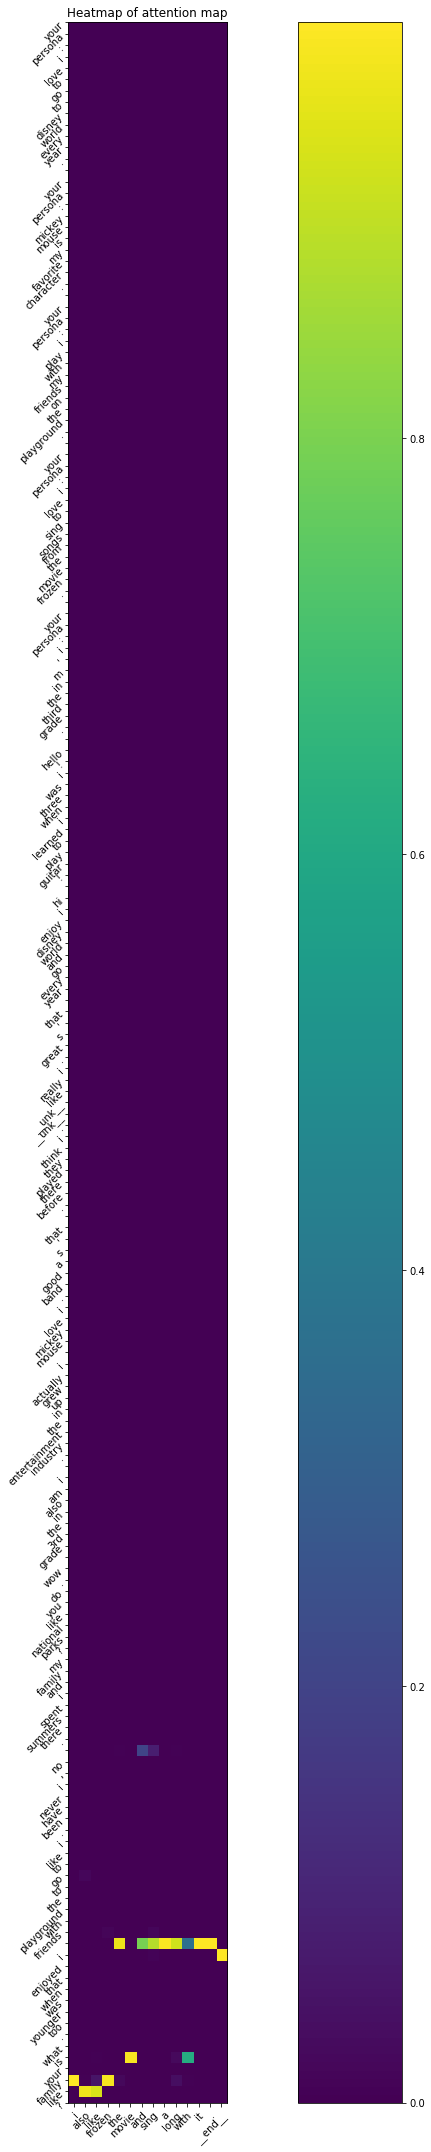

Input
--------------------------------------------------
['your', 'persona', ':', 'i', 'love', 'to', 'drink', 'wine', 'and', 'dance', 'in', 'the', 'moonlight', '.', '\n', 'your', 'persona', ':', 'i', 'am', 'very', 'strong', 'for', 'my', 'age', '.', '\n', 'your', 'persona', ':', 'i', "'", 'm', '100', 'years', 'old', '.', '\n', 'your', 'persona', ':', 'i', 'feel', 'like', 'i', 'might', 'live', 'forever', '.', '\n', 'hi', ',', 'how', 'are', 'you', 'doing', 'today', '?', '\n', 'good', '!', 'you', '!', 'celebrating', 'with', 'fellow', '__unk__', '\n', 'nice', '.', 'i', "'", 'm', 'playing', 'some', 'card', 'games', 'with', 'my', 'family', '.', '\n', 'that', 'sounds', 'like', 'fun', '.', 'i', 'like', 'wine', 'and', 'dancing', 'too', '!', '\n', 'same', '.', 'i', 'try', 'to', 'get', 'a', 'small', 'workout', 'in', 'a', 'three', 'mile', 'walk', 'for', 'me', 'is', 'key', '.', '\n', 'awesome', '!', 'walking', 'like', 'that', 'you', 'might', 'live', 'forever', 'like', 'me', '!', '!', '\n', 'that', "

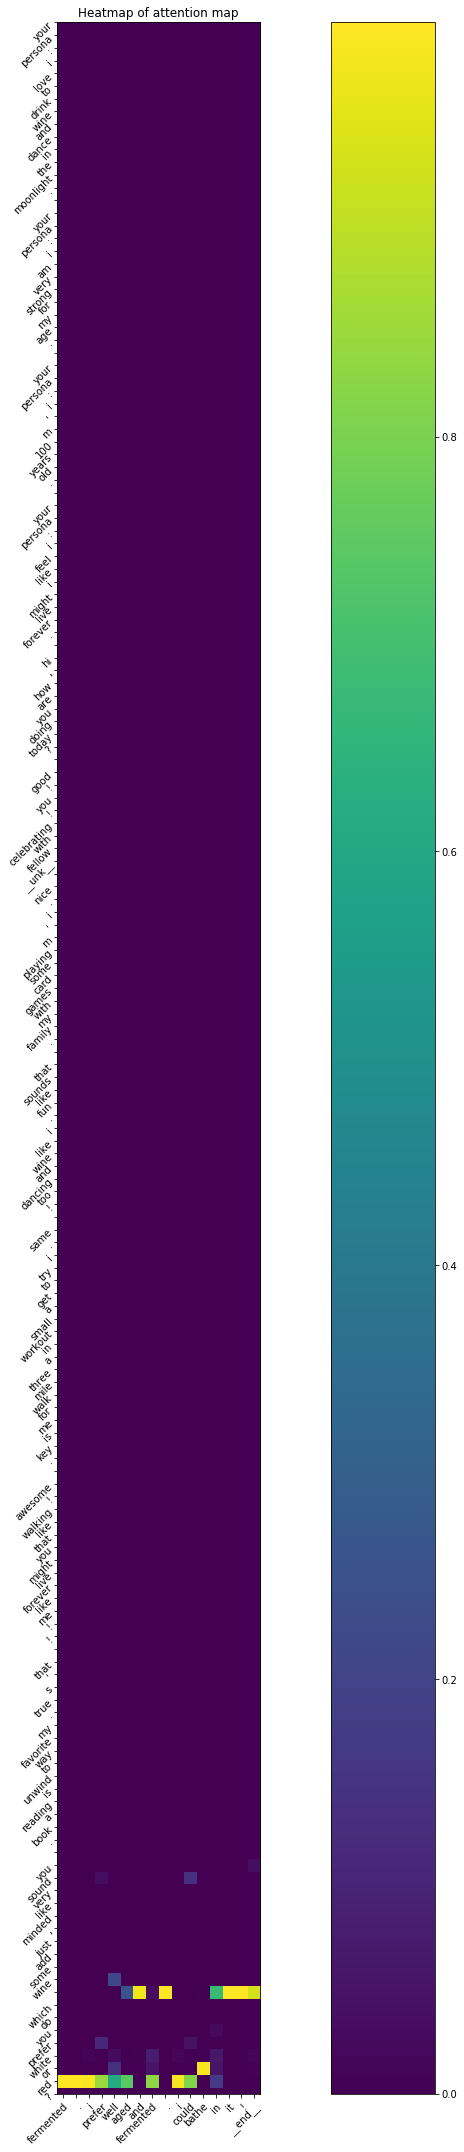

Input
--------------------------------------------------
['your', 'persona', ':', 'i', 'never', 'broke', 'a', 'bone', 'in', 'my', 'body', 'ever', 'in', 'my', 'life', '.', '\n', 'your', 'persona', ':', 'i', 'am', 'a', 'stunt', 'double', 'as', 'my', 'second', 'job', '.', '\n', 'your', 'persona', ':', 'i', 'read', 'twenty', 'books', 'a', 'year', '.', '\n', 'your', 'persona', ':', 'i', 'was', 'raised', 'in', 'a', 'single', 'parent', 'household', '.', '\n', 'your', 'persona', ':', 'i', 'only', 'eat', '__unk__', '.', '\n', 'hello', 'there', ',', 'how', 'are', 'you', 'today', '?', '\n', 'hello', '!', 'how', 'has', 'your', 'day', 'been', '?', '\n', 'great', 'so', 'far', 'preparing', 'my', 'kindergarten', 'lesson', 'for', 'tomorrow', '.', '\n', 'i', 'only', 'eat', '__unk__', 'foods', '\n', 'what', 'is', 'your', 'favorite', '?', 'i', 'eat', 'out', 'alot', 'with', 'friends', 'and', 'some', 'love', '__unk__', 'also', '.', '\n', 'i', 'like', '__unk__', 'salt', 'a', 'lot', '\n', 'no', 'salt', 'for',

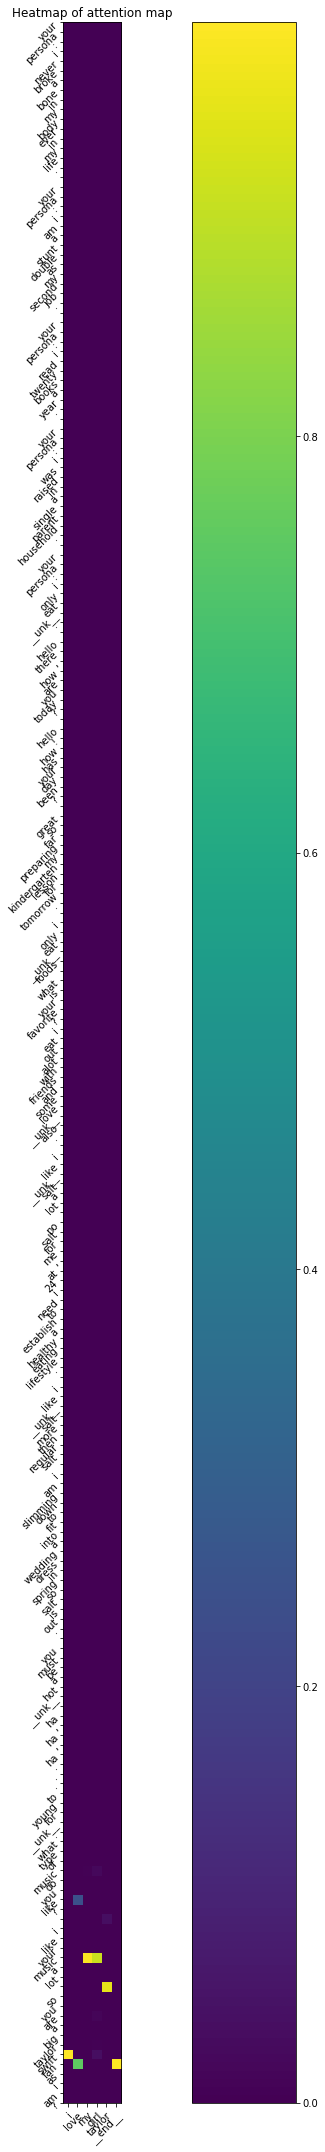

In [0]:
for i in range(5):
  inputs,target,attn_w_log_example = attention_weights(valid_loader)
  attention_map(attention_weights,inputs,target,True)

![Imgur](https://i.imgur.com/xodciCU.png)

## 1.2 Encoder Transformer

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'


opts = {}

opts['vocab_size'] = len(chat_dict)
opts['hidden_size'] = 256
opts['embedding_size'] = 256
opts['num_layers_enc'] = 2
opts['num_layers_dec'] = 2
opts['dropout'] = 0.3
opts['encoder_shared_lt'] = True

In [0]:
### add transformer encoder as optional encoder in seq2seq model.

# code below can help you to start it, but feel free to start from scratch

class EncoderTransformer(nn.Module):
  def __init__(self,vocab_size,embed_size,max_len,nhead, num_layers,hidden_size):
       
        super().__init__()
        # you need to add more things here
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.max_len = max_len
        self.nhead = nhead

        self.token_embed = nn.Embedding(self.vocab_size, embedding_dim=self.embed_size,padding_idx = 0)
        self.position_embed = nn.Embedding(self.max_len, embedding_dim= self.embed_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model = self.embed_size,nhead = self.nhead)  
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=self.num_layers)
        

  def forward(self, text_vec,text_lens):
          pos = torch.arange(text_vec.shape[1], device=text_vec.device).repeat(len(text_vec)).T.view(text_vec.shape[0],text_vec.shape[1])
          embedded = self.token_embed(text_vec)
          #embedded = pack_padded_sequence(embedded, text_lens, batch_first=True)
          

          #print(embedded.shape)
          embedded = self.token_embed(text_vec) + self.position_embed(pos)
          attention_mask = text_vec.ne(0)
          output = self.transformer(embedded, src_key_padding_mask=~attention_mask.T) 
          #output, output_lens = pad_packed_sequence(output, batch_first=True) 
          #print(output.shape)  
          #output, output_lens = pad_packed_sequence(output, batch_first=True)           
        
          return output,None,attention_mask
        

In [0]:
class seq2seq_modified(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderTransformer(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    max_len = 700,
                                    nhead = 4,
                                    num_layers=2
                                    
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [0]:
model = seq2seq_modified(opts).to('cuda')
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), 0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

In [0]:
plot_cache = []

best_val_loss = 100

for epoch in range(30):
    
    model.train()
    sum_loss = 0
    sum_tokens = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        text_vecs = batch['text_vecs'].to('cuda')
        target_vecs = batch['target_vecs'].to('cuda')
        
        encoded = model.encoder(text_vecs,batch['text_lens'])
        
        decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        
        scores = decoder_output.view(-1, decoder_output.size(-1))
        
        loss = criterion(scores, target_vecs.view(-1))
        sum_loss += loss.item()
        
        num_tokens = target_vecs.ne(0).long().sum().item()
        loss /= num_tokens
        
        sum_tokens += num_tokens
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            avg_train_loss = sum_loss/sum_tokens
            print("iter {} train loss = {}".format(i, sum_loss/sum_tokens))
            
    val_loss = 0
    val_tokens = 0
    for i, batch in enumerate(valid_loader):
        model.eval()
        
        text_vecs = batch['text_vecs'].to('cuda')
        target_vecs = batch['target_vecs'].to('cuda')
        
        encoded = model.encoder(text_vecs,batch['text_lens'])
        
        decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        
        scores = decoder_output.view(-1, decoder_output.size(-1))
        
        loss = criterion(scores, target_vecs.view(-1))
        
        num_tokens = target_vecs.ne(0).long().sum().item()
        
        val_tokens += num_tokens
        val_loss += loss.item()
        
    avg_val_loss = val_loss/val_tokens
    scheduler.step(avg_val_loss)
        
    print("Epoch {} valid loss = {}".format(epoch, avg_val_loss))
    
    plot_cache.append( (avg_train_loss, avg_val_loss) )
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        
        torch.save({
        'state_dict': model.state_dict(),
        'opts': opts,
        'plot_cache': plot_cache,
            }, f'./transformer_model_best_{epoch}.pt')

iter 0 train loss = 9.83485371162928
iter 100 train loss = 6.01297530749492
iter 200 train loss = 5.737520528378872
iter 300 train loss = 5.528835929471299
iter 400 train loss = 5.336486749898553
iter 500 train loss = 5.169026935922143
iter 600 train loss = 5.02412978945309
iter 700 train loss = 4.9082914350852285
iter 800 train loss = 4.8135576815915435
iter 900 train loss = 4.731861102859363
iter 1000 train loss = 4.663779314612011
Epoch 0 valid loss = 4.058064096378614
iter 0 train loss = 4.101857592960023
iter 100 train loss = 3.9629194066235574
iter 200 train loss = 3.945272993089514
iter 300 train loss = 3.939024738598039
iter 400 train loss = 3.931997121679518
iter 500 train loss = 3.920122376595068
iter 600 train loss = 3.909034817536077
iter 700 train loss = 3.902583856258832
iter 800 train loss = 3.8960861922359853
iter 900 train loss = 3.891311299278281
iter 1000 train loss = 3.8839808430845792
Epoch 1 valid loss = 3.8877160174529286
iter 0 train loss = 3.6905942542530665
it

KeyboardInterrupt: ignored

## You present here:

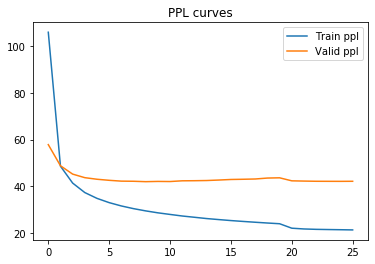

In [0]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

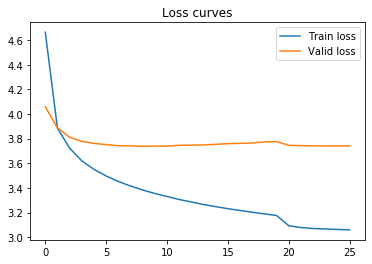

In [0]:
epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

# Part 2 Decoding

# 2.1 Nucleus Sampling

In [12]:
model = seq2seq(opts).to('cuda')
model.load_state_dict(torch.load('chat_model_best_22.pt')['state_dict'])

<All keys matched successfully>

In [0]:
def top_p_filtering(logits, top_p):
    logits = logits.view(-1)
    assert logits.dim() == 1
    if top_p > 0.0 and top_p < 1.0:
        filter_value = -float('Inf')
        all_scores = torch.softmax(logits, dim=-1)
        sorted_scores, sorted_indices = torch.sort(all_scores, descending=True)
        cumulative_scores = torch.cumsum(sorted_scores, dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_scores > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value

    return logits

In [0]:
import torch.nn.functional as F
def nucleus_sampling(model, batch, batch_size, top_p):
    model.eval()
        
    text_vecs = batch['text_vecs'].to(current_device)

    encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
    
    encoder_output, encoder_hidden, attention_mask = encoded
        
    # 1 is __start__
    starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
    decoder_hidden = encoder_hidden

    # greedy decoding here        
    preds = [starts]
    scores = []

    # track if each sample in the mini batch is finished
    # if all finished, stop predicting
    finish_mask = torch.Tensor([0]*batch_size).byte().to(model.decoder.embedding.weight.device)
    xs = starts
    _attn_w_log = []

    for ts in range(100):
        decoder_output, decoder_hidden, attn_w_log = model.decoder(xs, decoder_hidden, encoded)  # decoder_output: [batch, time, vocab]
        
        ################## sampling begins
        filtered_logits = top_p_filtering(decoder_output, top_p) # shape: [1], dim = 1
        all_scores = torch.softmax(filtered_logits, dim=-1) # shape: [1], dim = 1
        _preds = torch.multinomial(all_scores, 1).view(1,1) # shape: [1,,1], dim = 2
        _scores = torch.log(all_scores[_preds]).view(1,1) # shape: [1,,1], dim = 2
        ################## sampling ends
        
        preds.append(_preds)
        _attn_w_log.append(attn_w_log)
        scores.append(_scores.view(-1)*(finish_mask == 0).float())

        finish_mask += (_preds == 2).byte().view(-1)
        
        if not (torch.any(~finish_mask.bool())):
            break
        
        xs = _preds
    
    preds = torch.cat(preds, dim=-1)
    
    return preds, torch.stack(scores, dim=0).sum(dim=0) # prediction output, sum of log_prob


In [0]:
import numpy as np
RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)
# random choice
choice = np.random.choice(len(valid_dataset), 1)[0]
inputs = RETOK.findall(valid_dataset.samples[choice]['eval_labels'][0])

test_batch = {
    'text_vecs': torch.tensor([chat_dict.t2v(inputs)], dtype=torch.long, device=model.decoder.embedding.weight.device),
    'text_lens': torch.tensor([len(inputs)], dtype=torch.long),
    'use_packed': True,
}

In [16]:
# random choice
import numpy as np
batch_size = 1

# shuffling to make different examples
valid_loader_single = DataLoader(valid_dataset, shuffle=True, collate_fn=batchify, batch_size=batch_size)
valid_sample = next(iter(valid_loader_single))
print(f"Input : {chat_dict.v2t(valid_sample['text_vecs'][0].tolist())}\n")

Input : your persona : i am 24 years old . 
 your persona : my favorite singer is taylor swift . 
 your persona : i work at a school as a kindergarten teacher . 
 your persona : i ' m getting married in the spring . 
 how are you doing today 
 i ' m doing great and how are you ? 
 well the clouds are kind of dim 
 it is raining here today and cool . 
 do you have powers too 
 i ' ve power and so does the school i work at . 
 what is your best power 
 my power is __unk__ tasking with quick response . 
 can you fly as well 
 no , can you ? i am young so i haven ' t got that skill yet . 
 it is the most wonderful things 
 sounds like it . i ' m flying by plane soon . 
 so you can fly ? i am so glad 
 i am getting married soon ! 
 that sounds great . do they have powers ?



In [17]:
top_p_list = [0.1, 0.5, 0.9]
avg_sum_log_probs_list = []
unique_tokens = []
for top_p in top_p_list:
    print("probability = ", top_p)
    outputs = []
    sum_log_probs = []
    for _ in range(100): # product 100 decodings
        output, sum_log_prob = nucleus_sampling(model, valid_sample, 1, top_p)
        outputs.extend(output.view(-1).tolist())
        sum_log_probs.append(sum_log_prob)
        print(chat_dict.v2t(output[0].tolist())) # print decoded sentence
    avg_sum_log_probs = torch.mean(torch.stack(sum_log_probs)) # average sum of log probs
    avg_sum_log_probs_list.append(avg_sum_log_probs)
    unique_tokens.append(len(set(outputs)) - 2) # unique tokens (-2: minus start and finish token)

probability =  0.1
__start__ they are my favorite . i ' m a bit of a loner __end__
__start__ they are my favorite . i ' m a big fan of the country __end__
__start__ they are the best . they are my favorite __end__
__start__ they are my favorite . i ' m a big fan of the country __end__
__start__ they are my favorite . i ' m a bit of a loner __end__
__start__ they are the best . they are my favorite __end__
__start__ they are my favorite . i ' m a huge fan of them __end__
__start__ they are my favorite . i ' m a bit of a loner __end__
__start__ they are the best . they are my favorite __end__
__start__ they are the best . they are my favorite __end__
__start__ they are the best . they are my favorite __end__
__start__ they are my favorite . i ' m a big fan of the country __end__
__start__ they are the best . they are my favorite __end__
__start__ they are the best . they are my favorite __end__
__start__ they are my favorite . i ' m a bit of a loner __end__
__start__ they are my favorite

## You present here:

No handles with labels found to put in legend.


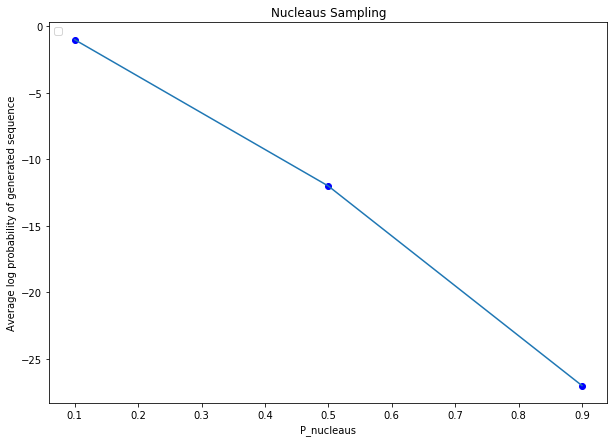

In [18]:
avg_sum_log_probs_list = [int(i) for i in avg_sum_log_probs_list]

import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
plt.plot(top_p_list, avg_sum_log_probs_list, 'bo')
plt.plot(top_p_list, avg_sum_log_probs_list)
plt.title('Nucleaus Sampling')
plt.ylabel('Average log probability of generated sequence')
plt.xlabel('P_nucleaus')
plt.legend(loc = 2)

No handles with labels found to put in legend.


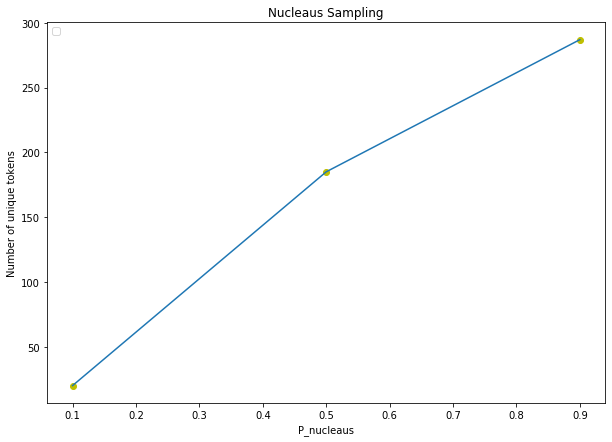

In [19]:
plt.figure(figsize = (10,7))
plt.plot(top_p_list, unique_tokens, 'yo')
plt.plot(top_p_list, unique_tokens)
plt.title('Nucleaus Sampling')
plt.ylabel('Number of unique tokens')
plt.xlabel('P_nucleaus')
plt.legend(loc = 2)

## 2.2 N-Gram blocking

In [0]:
import math
from operator import attrgetter

class _HypothesisTail(object):
    """Hold some bookkeeping about a hypothesis."""

    # use slots because we don't want dynamic attributes here
    __slots__ = ['timestep', 'hypid', 'score', 'tokenid']

    def __init__(self, timestep, hypid, score, tokenid):
        self.timestep = timestep
        self.hypid = hypid
        self.score = score
        self.tokenid = tokenid

class Beam(object):
    """
    This class serves to keep info about partial hypothesis and perform the beam step
    """
    
    def __init__(
        self,
        beam_size,
        padding_token=0,
        bos_token=1,
        eos_token=2,
        min_length=3,
        min_n_best=3,
        device='cpu',
        # for iterbeam below
        # similarity_metric='hamming',
        # similarity_threshold=0,
        ngram = 3
    ):
        
        self.beam_size = beam_size
        self.min_length = min_length
        self.eos = eos_token
        self.bos = bos_token
        self.pad = padding_token
        self.device = device
        # recent score for each hypo in the beam
        self.scores = None
        # self.scores values per each time step
        self.all_scores = [torch.Tensor([0.0] * beam_size).to(self.device)]
        # backtracking id to hypothesis at previous time step
        self.bookkeep = []
        # output tokens at each time step
        self.outputs = [
            torch.Tensor(self.beam_size).long().fill_(self.bos).to(self.device)
        ]
        # keeps tuples (score, time_step, hyp_id)
        self.finished = [] # store finished sequences
        self.eos_top = False
        self.eos_top_ts = None
        self.n_best_counter = 0
        self.min_n_best = min_n_best
        self.partial_hyps = [[self.bos] for i in range(beam_size)] # partial hypotheses

        # iterbeam related below
        self.history_hyps = []
        self.ngram = ngram
        # self.similarity_metric = similarity_metric
        # self.similarity_threshold = similarity_threshold
        self.banned_tokens = set()
        
    def get_output_from_current_step(self):
        """Get the output at the current step."""
        return self.outputs[-1]

    def get_backtrack_from_current_step(self):
        """Get the backtrack at the current step."""
        return self.bookkeep[-1]
    
    ##################### ITER-BEAM BLOCKING PART START #####################

    #N-gram blocking
    def find_ngrams(self, active_hyp):
        n = self.ngram
        history_ngrams = []
        for ngram in zip(*[list(active_hyp)[i:] for i in range(n)]):
            history_ngrams.append(ngram)
        history_ngrams = list(set(history_ngrams))
        return history_ngrams
    
    ##################### ITER-BEAM BLOCKING PART END ########################
    def select_paths(self, logprobs, prior_scores, previous_hyps):
        """Select the next vocabulary item in these beams."""
        # beam search actually looks over all hypotheses together so we flatten
        beam_scores = logprobs + prior_scores.unsqueeze(1).expand_as(logprobs)
        
        ###### iterbeam blocking part begins
        n = self.ngram
        current_length = len(self.all_scores)
        if n > 0:
          if current_length > 0:
              for hyp_id in range(beam_scores.size(0)): # for each active hyp in the hyp set
                  banned_tokens = [] # initialize empty banned tokens for each active hyp
                  active_hyp = tuple(self.partial_hyps[hyp_id])
                  existed_ngrams = self.find_ngrams(active_hyp) # list of existed ngrams in this active hypothesis
                  for tok_id in range(logprobs.size(-1)): # append each token from vocab to see which to block
                      if n == 1: # ngram = 1
                          if tuple([tok_id]) in existed_ngrams:
                              banned_tokens.append(tok_id)
                      elif n > 1: # ngram = 2,3,4...
                          prev = list(active_hyp)[-(n-1):]
                          prev.append(tok_id)
                          if tuple(prev) in existed_ngrams:
                              banned_tokens.append(tok_id)
                  banned_tokens = list(banned_tokens)
                  beam_scores_copy = beam_scores.clone()
                  if len(banned_tokens) > 0:
                      beam_scores[hyp_id][banned_tokens] = -10e20
                      # assert beam_scores != beam_scores_copy
                      # print(beam_scores.shape, type(beam_scores))
                  # print(banned_tokens)
                  # print(beam_scores.shape)
        flat_beam_scores = beam_scores.view(-1)
        best_scores, best_idxs = torch.topk(flat_beam_scores, self.beam_size, dim=-1)
        voc_size = logprobs.size(-1)
        ###### iterbeam blocking part ends

        # get the backtracking hypothesis id as a multiple of full voc_sizes
        hyp_ids = best_idxs / voc_size
        # get the actual word id from residual of the same division
        tok_ids = best_idxs % voc_size
        
        return (hyp_ids, tok_ids, best_scores)
    
    def advance(self, logprobs, previous_hyps):
        """Advance the beam one step."""
        current_length = len(self.all_scores) - 1
        if current_length < self.min_length:
            # penalize all eos probs to make it decode longer
            for hyp_id in range(logprobs.size(0)):
                logprobs[hyp_id][self.eos] = -10e5

        if self.scores is None:
            logprobs = logprobs[0:1]  # we use only the first hyp now, since they are all same
            self.scores = torch.zeros(1).type_as(logprobs).to(logprobs.device) # at first timestep, scores are initialized as zeros
        
        hyp_ids, tok_ids, self.scores = self.select_paths(logprobs, self.scores, previous_hyps)
        
        # clone scores here to avoid referencing penalized EOS in the future!
        self.all_scores.append(self.scores.clone())

        self.outputs.append(tok_ids)
        self.bookkeep.append(hyp_ids)
        self.partial_hyps = [
            self.partial_hyps[hyp_ids[i]] + [tok_ids[i].item()]
            for i in range(self.beam_size)
        ] # the new partial hypotheses is: previous hyp + newly-selected token
        self.history_hyps.extend(self.partial_hyps)

        #  check new hypos for eos label, if we have some, add to finished
        for hypid in range(self.beam_size):
            if self.outputs[-1][hypid] == self.eos:
                self.scores[hypid] = -10e5
                #  this is finished hypo, adding to finished
                eostail = _HypothesisTail(
                    timestep=len(self.outputs) - 1,
                    hypid=hypid,
                    score=self.all_scores[-1][hypid],
                    tokenid=self.eos,
                )
                self.finished.append(eostail)
                self.n_best_counter += 1

        if self.outputs[-1][0] == self.eos:
            self.eos_top = True
            if self.eos_top_ts is None:
                self.eos_top_ts = len(self.outputs) - 1
    
    def is_done(self):
        """Return whether beam search is complete."""
        return self.eos_top and self.n_best_counter >= self.min_n_best

    def get_top_hyp(self):
        """
        Get single best hypothesis.
        :return: hypothesis sequence and the final score
        """
        return self._get_rescored_finished(n_best=1)[0]

    def _get_hyp_from_finished(self, hypothesis_tail):
        """
        Extract hypothesis ending with EOS at timestep with hyp_id.
        :param timestep:
            timestep with range up to len(self.outputs) - 1
        :param hyp_id:
            id with range up to beam_size - 1
        :return:
            hypothesis sequence
        """
        hyp_idx = []
        endback = hypothesis_tail.hypid
        for i in range(hypothesis_tail.timestep, -1, -1):
            hyp_idx.append(
                _HypothesisTail(
                    timestep=i,
                    hypid=endback,
                    score=self.all_scores[i][endback],
                    tokenid=self.outputs[i][endback],
                )
            )
            endback = self.bookkeep[i - 1][endback]

        return hyp_idx

    def _get_pretty_hypothesis(self, list_of_hypotails):
        """Return hypothesis as a tensor of token ids."""
        return torch.stack([ht.tokenid for ht in reversed(list_of_hypotails)])

    def _get_rescored_finished(self, n_best=None, add_length_penalty=False):
        """
        Return finished hypotheses according to adjusted scores.
        Score adjustment is done according to the Google NMT paper, which
        penalizes long utterances.
        :param n_best:
            number of finalized hypotheses to return
        :return:
            list of (tokens, score) pairs, in sorted order, where:
              - tokens is a tensor of token ids
              - score is the adjusted log probability of the entire utterance
        """
        # if we never actually finished, force one
        if not self.finished:
            self.finished.append(
                _HypothesisTail(
                    timestep=len(self.outputs) - 1,
                    hypid=0,
                    score=self.all_scores[-1][0],
                    tokenid=self.eos,
                )
            )

        rescored_finished = []
        for finished_item in self.finished:
            if add_length_penalty:
                current_length = finished_item.timestep + 1
                # these weights are from Google NMT paper
                length_penalty = math.pow((1 + current_length) / 6, 0.65)
            else:
                length_penalty = 1
            rescored_finished.append(
                _HypothesisTail(
                    timestep=finished_item.timestep,
                    hypid=finished_item.hypid,
                    score=finished_item.score / length_penalty,
                    tokenid=finished_item.tokenid,
                )
            )

        # Note: beam size is almost always pretty small, so sorting is cheap enough
        srted = sorted(rescored_finished, key=attrgetter('score'), reverse=True)

        if n_best is not None:
            srted = srted[:n_best]

        return [
            (self._get_pretty_hypothesis(self._get_hyp_from_finished(hyp)), hyp.score)
            for hyp in srted
        ]

In [0]:
def reorder_encoder_states(encoder_states, indices):
        """Reorder encoder states according to a new set of indices."""
        enc_out, hidden, attention_mask = encoder_states

        # LSTM or GRU/RNN hidden state?
        if isinstance(hidden, torch.Tensor):
            hid, cell = hidden, None
        else:
            hid, cell = hidden

        if not torch.is_tensor(indices):
            # cast indices to a tensor if needed
            indices = torch.LongTensor(indices).to(hid.device)

        hid = hid.index_select(1, indices)
        if cell is None:
            hidden = hid
        else:
            cell = cell.index_select(1, indices)
            hidden = (hid, cell)

        enc_out = enc_out.index_select(0, indices)
        attention_mask = attention_mask.index_select(0, indices)

        return enc_out, hidden, attention_mask
    
    
def reorder_decoder_incremental_state(incremental_state, inds):
    if torch.is_tensor(incremental_state):
        # gru or lstm
        return torch.index_select(incremental_state, 1, inds).contiguous()
    elif isinstance(incremental_state, tuple):
        return tuple(
            self.reorder_decoder_incremental_state(x, inds)
            for x in incremental_state)

def get_nbest_list_from_beam(beam, dictionary, n_best=None, add_length_penalty=False):
    if n_best is None:
        n_best = beam.min_n_best
    nbest_list = beam._get_rescored_finished(n_best=n_best, add_length_penalty=add_length_penalty)
    
    nbest_list_text = [(dictionary.v2t(i[0].cpu().tolist()), i[1].item()) for i in nbest_list]
    
    return nbest_list_text

In [0]:
def generate_with_beam(beam_size, min_n_best, model, batch, batch_size, previous_hyps=None, ngram=3, verbose=False):
    """
    This function takes a model, batch, beam settings and performs decoding with a beam
    """
    # create a list of beam classes
    beams = [Beam(beam_size, min_n_best=min_n_best, eos_token=chat_dict.word2ind['__end__'], padding_token=chat_dict.word2ind['__null__'], bos_token=chat_dict.word2ind['__start__'], device=current_device, ngram=ngram) for _ in range(batch_size)]
    repeated_inds = torch.arange(batch_size).to(current_device).unsqueeze(1).repeat(1, beam_size).view(-1)
    
    text_vecs = batch['text_vecs'].to(current_device)

    encoder_states = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
    
    model.eval()
    
    encoder_states = reorder_encoder_states(encoder_states, repeated_inds)  # no actual reordering here, but repeating beam size times each sample in the minibatch
    encoder_output, encoder_hidden, attention_mask = encoder_states
    
    incr_state = encoder_hidden  # we init decoder hidden with last encoder_hidden; incr_state: current state of each timestep
    
    # 1 is a start token id
    starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size*beam_size, 1).long()  # expand to batch_size * beam_size
    decoder_input = starts
    
    with torch.no_grad():
        for ts in range(100):
            if all((b.is_done() for b in beams)):
                break
            score, incr_state, attn_w_log = model.decoder(decoder_input, incr_state, encoder_states)
            score = score[:, -1:, :]  # take last time step and eliminate the dimension, shape: beam_size * batch_size * vocab_size
            score = score.view(batch_size, beam_size, -1) # shape: batch_size * beam_size * vocab_size
            
            score = torch.log_softmax(score, dim=-1) # shape: batch_size * beam_size * vocab_size
         
            for i, b in enumerate(beams):
                if not b.is_done():
                    # make mock previous_hyps if not used #
                    if previous_hyps is None:
                        previous_hyps = [{} for i in range(batch_size)]
                    
                    # advance the beam
                    b.advance(score[i], previous_hyps[i])

            # get the hidden states of the beam path selected
            incr_state_inds = torch.cat([beam_size * i + b.get_backtrack_from_current_step() for i, b in enumerate(beams)])
            incr_state = reorder_decoder_incremental_state(incr_state, incr_state_inds)
            selection = torch.cat([b.get_output_from_current_step() for b in beams]).unsqueeze(-1)
            decoder_input = selection

    beam_preds_scores = [list(b.get_top_hyp()) for b in beams]

    if verbose:
        for bi in range(batch_size):
            print(f'batch {bi}')
            for i in get_nbest_list_from_beam(beams[bi], chat_dict, n_best=min_n_best):
                print(i)
    
    return beam_preds_scores, beams

## You present here:

In [23]:
# random choice
import numpy as np
batch_size = 1
beam_size = 20
beam_n_best = 10
ngram_list = [1,2,3]

# shuffling to make different examples
valid_loader_single = DataLoader(valid_dataset, shuffle=True, collate_fn=batchify, batch_size=batch_size)
valid_sample = next(iter(valid_loader_single))
print(f"Input : {chat_dict.v2t(valid_sample['text_vecs'][0].tolist())}\n")

Input : your persona : i coach little league baseball . 
 your persona : i ' ve five sons . 
 your persona : coffee is my preferred beverage . 
 your persona : i drive a mini van . 
 your persona : i also like a glass of wine in the evenings . 
 hello , i hope you have a better job than i do 
 hi . i ' m a little league coach . i have 5 sons and a mini van . 
 five sons ? do they play on your team ? 
 yes , and therefore i drink a lot of coffee , it is my favorite . what is yours ? 
 cool and coffee is great , as a graduate student i pull tons of all __unk__ 
 i like to have wine some nights on __unk__ as well . 
 i don ' t enjoy wine but i do enjoy psychology journals 
 what kind of job do you have ? 
 i walk dogs to pay for college and food 
 that is not such a bad job . it sounds fun . 
 it is not stable enough and it does not pay enough 
 but at least you get lots of fresh air . 
 i get enough of that when i go kayaking



In [24]:
for ngram in ngram_list:
    print("\n ngram : {}: ".format(ngram))
    outputs, prefix_dict = generate_with_beam(beam_size, beam_n_best, model, valid_sample, batch_size=batch_size, ngram=ngram, verbose=True)


 ngram : 1: 
batch 0
('__start__ do you have any pets ? __end__', -6.142935752868652)
('__start__ do you have any hobbies ? __end__', -6.1642255783081055)
('__start__ what is your favorite food ? __end__', -7.279752731323242)
('__start__ it was nice talking to you . __end__', -7.529592514038086)
('__start__ do you have any kids ? __end__', -7.660855293273926)
('__start__ it was nice chatting with you . __end__', -7.712512969970703)
('__start__ what is your favorite color ? __end__', -7.982129096984863)
('__start__ do you have any children ? __end__', -8.121708869934082)
('__start__ do you have a job ? __end__', -8.189969062805176)
('__start__ do you have a favorite food ? __end__', -8.629035949707031)

 ngram : 2: 
batch 0
('__start__ do you have any pets ? __end__', -6.142935752868652)
('__start__ do you have any hobbies ? __end__', -6.1642255783081055)
('__start__ what do you do for work ? __end__', -6.632382392883301)
('__start__ what do you do for fun ? __end__', -7.00352478027343

# Part 3 Interactive chat

In [0]:
def ChatDataset_inter(conversation): 
  sample = {}
  _inp_toked = RETOK.findall(conversation['text'])
  _inp_toked_id = chat_dict.t2v(_inp_toked)
  sample['text_vecs'] = torch.tensor(_inp_toked_id, dtype=torch.long)
  sample['text_vecs'] = sample['text_vecs'].view(1,-1)

  _tar_toked = RETOK.findall(conversation['eval_labels']) + ['__end__']
  _tar_toked_id = chat_dict.t2v(_tar_toked)
  sample['target_vecs'] = torch.tensor(_tar_toked_id, dtype=torch.long)
  sample['text_lens'] = torch.as_tensor(len(sample['text_vecs']), dtype=torch.int64,device='cpu')
  sample['use_packed'] = False
  return(sample)

In [0]:

def nucleus_sampling_con(model, batch, batch_size, top_p):
    model.eval()
        
    text_vecs = batch['text_vecs'].to(current_device)

    encoded = model.encoder(text_vecs,batch['text_lens'])
    
    encoder_output, encoder_hidden, attention_mask = encoded
        
    # 1 is __start__
    starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
    decoder_hidden = encoder_hidden

    # greedy decoding here        
    preds = [starts]
    scores = []

    # track if each sample in the mini batch is finished
    # if all finished, stop predicting
    finish_mask = torch.Tensor([0]*batch_size).byte().to(model.decoder.embedding.weight.device)
    xs = starts
    _attn_w_log = []

    for ts in range(100):
        decoder_output, decoder_hidden, attn_w_log = model.decoder(xs, decoder_hidden, encoded)  # decoder_output: [batch, time, vocab]
        
        ################## sampling begins
        filtered_logits = top_p_filtering(decoder_output, top_p) # shape: [1], dim = 1
        all_scores = torch.softmax(filtered_logits, dim=-1) # shape: [1], dim = 1
        _preds = torch.multinomial(all_scores, 1).view(1,1) # shape: [1,,1], dim = 2
        _scores = torch.log(all_scores[_preds]).view(1,1) # shape: [1,,1], dim = 2
        ################## sampling ends
        
        preds.append(_preds)
        _attn_w_log.append(attn_w_log)
        scores.append(_scores.view(-1)*(finish_mask == 0).float())

        finish_mask += (_preds == 2).byte().view(-1)
        
        if not (torch.any(~finish_mask.bool())):
            break
        
        xs = _preds
    
    preds = torch.cat(preds, dim=-1)
    
    return preds, torch.stack(scores, dim=0).sum(dim=0) # prediction output, sum of log_prob

## You present here:

In [0]:
other_persona = 'your persona: i am a vegan and i love hummus.\\nyour persona: i love rollercoasters and sky diving.\\nyour persona: i do like watching cooking shows.\\nyour persona: i am not a good swimmer at all.'
your_conver = '\\nhi!'

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'


opts = {}

opts['vocab_size'] = len(chat_dict)
opts['hidden_size'] = 256
opts['embedding_size'] = 256
opts['num_layers_enc'] = 2
opts['num_layers_dec'] = 2
opts['dropout'] = 0.3
opts['encoder_shared_lt'] = True

In [0]:
model = seq2seq_modified(opts).to('cuda')
model.load_state_dict(torch.load('transformer_model_best_8.pt')['state_dict'])

<All keys matched successfully>

In [0]:
def conversation_inter(other_persona,your_conver_start):
  conversation = {}
  conversation ["text"] = other_persona + your_conver_start
  conversation["eval_labels"] = ''
  other_response = conversation["eval_labels"]
  batch = ChatDataset_inter(conversation)

  print(other_persona)
  print(your_conver_start)

  for i in range(3):
    your_reply = input('your response')
    if i == 0:
      conversation ["text"] = conversation ["text"] + '\\n' + your_reply 
    else: 
      conversation ["text"] = conversation ["text"] + '\\n' +other_response + '\\n' + your_reply 
    conversation["eval_labels"] = ''
    batch = ChatDataset_inter(conversation)
    output, sum_log_prob = nucleus_sampling_con(model,batch,1,0.3)
    other_response = chat_dict.v2t(output[0].tolist())
    print(other_response)
  print('-' * 50)
  for sentence in conversation ["text"].split("\\n"):
    print(sentence)
  print(other_response)

In [0]:
conversation_inter(other_persona,your_conver)

your persona: i am a vegan and i love hummus.\nyour persona: i love rollercoasters and sky diving.\nyour persona: i do like watching cooking shows.\nyour persona: i am not a good swimmer at all.
\nhi!
your responseHello!
__start__ hi , how are you today ? __end__
your responseI am good! you?
__start__ that is cool . i am in the navy __end__
your responseThat sounds interesting!
__start__ i ' m in the navy , so i can not wait to retire __end__
--------------------------------------------------
your persona: i am a vegan and i love hummus.
your persona: i love rollercoasters and sky diving.
your persona: i do like watching cooking shows.
your persona: i am not a good swimmer at all.
hi!
Hello!
__start__ hi , how are you today ? __end__
I am good! you?
__start__ that is cool . i am in the navy __end__
That sounds interesting!
__start__ i ' m in the navy , so i can not wait to retire __end__
